# PDE-FIND for Burger's Equation

This notebook demonstrates PDE-FIND on Burger's equation with an added diffusive term.
$$
u_t + uu_x = 0.1u_{xx}
$$
The solution given is a single travelling wave, starting out as a Gaussian.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings("ignore")

import numpy as np
from numpy.random import default_rng
import pandas as pd

import os
import sys; sys.path.append('../')
from PDE_FIND import *
from PDE_FIND_RUDY import TrainSTRidge as TrainSTRidgeRudy

import sys; sys.path.append('../../parametric-discovery/')
from best_subset import *
from frols import frols
from p_linear_regression import PLinearRegression
from r_pca import R_pca
from pde_diff_new import RPCA
from RobustPCA.rpca import RobustPCA

import scipy.io as sio
from scipy.signal import savgol_filter, wiener
from scipy.integrate import trapz
import itertools

from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression as SkLinearRegression
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from abess.linear import LinearRegression
import pysindy as ps

from os.path import join as join_path
FIGURE_EXPORT_PATH = "/Users/pongpisit/Documents/figure_export/"

def evaluate_coefficients(prediected_coeffs):
    GROUND = np.array([0.1, -1])
    errs = 100*np.abs(GROUND-np.array(prediected_coeffs).flatten())/np.abs(GROUND)
    return errs.mean(), errs.std()

def percent_coeff(pred, ground):
    return 100*np.abs(pred-ground)/np.abs(ground)

import torch, sympytorch
import torch.nn as nn
import torch.nn.functional as F
from sympy import symbols, simplify, lambdify
from mathparser import math_eval
from varname import nameof
from misc import h5file

from findiff import FinDiff
from tqdm import tqdm, trange

Sklearn's version: 1.2.2
mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.


In [2]:
data = sio.loadmat('../Datasets/burgers.mat')
u = (data['usol']).real
x = (data['x'][0]).real
t = (data['t'][:,0]).real
dt = t[1]-t[0]
dx = x[2]-x[1]
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

#### Add noise and test functionality 

In [3]:
print("----- Clean -----")
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=x,
    is_uniform=True,
)

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=0.1, alpha=1e-5, normalize_columns=False)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(np.expand_dims(u, -1), t=dt)
model.print()

Ut, R, rhs_des = build_linear_system(u, dt, dx, D=3, P=3, time_diff = 'FD', space_diff = 'FD')
rhs_des = rhs_des[1:]
R = R[:, 1:].real; Ut = Ut.real
w = TrainSTRidge(R,Ut,10**-5,0.1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

print()

print("----- Add 30% noise -----")
np.random.seed(0)
noise_lv = float(30)
print(noise_lv)
noise = 0.01*np.abs(noise_lv)*(u.std())*np.random.randn(u.shape[0],u.shape[1])
un = u + noise
np.mean(noise), np.std(noise), np.max(noise), np.min(noise)

Utn, Rn, rhs_des = build_linear_system(un, dt, dx, D=3, P=3, time_diff = 'poly',
                                       deg_x = 4, deg_t = 4, 
                                       width_x = 10, width_t = 10)
rhs_des = rhs_des[1:]
Rn = Rn[:, 1:].real; Utn = Utn.real
# Solve with STRidge
w = TrainSTRidge(Rn,Utn,10**-5,1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

----- Clean -----
STLSQ model: 
(x0)' = 0.100 x0_11 + -1.001 x0x0_1
l0_penalty: 1.6123253173828125
PDE derived using STRidge
u_t = (-1.000403 +0.000000i)uu_{x}
    + (0.100145 +0.000000i)u_{xx}
   

----- Add 30% noise -----
30.0
l0_penalty: 1.93969921875
PDE derived using STRidge
u_t = (-0.775461 +0.000000i)uu_{x}
   


## Getting started

In [4]:
## Goals: implement my own optimizer and differentiation_method class!
from functools import partial
import derivative
from tvregdiff import TVRegDiff, tvregdiff, numdiff, pysindydiff, savgol_denoise

class KalmanDiff(ps.BaseDifferentiation):
    def __init__(self, alpha, poly_deg=None, rpca_lambda=None, d=1, axis=1, is_uniform=True, periodic=False):
        super(KalmanDiff, self).__init__()
        # Kalman diff
        self.alpha = alpha
        self.diff_func = derivative.Kalman(alpha=self.alpha)
        self.d = d
        self.diff = partial(pysindydiff, **{"diff_method":self.diff_func, "order":self.d})
        # Savgol denoising
        self.poly_deg = poly_deg
        if poly_deg is not None:
            if poly_deg%2 == 0: window_length = self.poly_deg + 1
            else: window_length = self.poly_deg + 2
            self.denoise = partial(savgol_denoise, **{"window_length":window_length, "poly_deg":self.poly_deg})
        else:
            self.denoise = lambda _: _
        # Robust PCA
        self.rpca_lambda = rpca_lambda
        # Other info...
        self.axis = axis
        self.is_uniform = is_uniform
        self.periodic = periodic
        # data transformation
        # rs = np.ones(2).astype(np.int32); rs[self.axis] = -1; rs = tuple(rs)
        self.transform = np.vectorize(composite_function(self.diff, self.denoise, left2right=True), signature="(m),(m)->(m)")
    # _differentiate
    def _differentiate(self, x, t):
        in_shape = x.shape
        if len(in_shape) == 2: x = np.expand_dims(x, -1) # x should now be 3-dimensional
        if isinstance(t, float) and self.is_uniform: 
            t = np.linspace(0, stop=t*(x.shape[self.axis]-1), num=x.shape[self.axis])
        out = []
        # wrt to x var
        if self.axis == 0:
            for i in range(x.shape[-1]):
                # use lambda and partial from functools to help shorten the code
                # diff = np.hstack([self.denoise(self.diff(x[:, j:j+1, i], t)).reshape(-1, 1) 
                #                   for j in range(x.shape[1])])
                # diff = np.hstack([self.transform(x[:, j:j+1, i], t) for j in range(x.shape[1])])
                # diff = np.vectorize(self.transform, signature="(m),(m)->(m)")(x[:,:,i].T, t).T
                diff = self.transform(x[:,:,i].T, t).T
                if self.rpca_lambda is not None:
                    diff = self._get_low_rank(diff)
                out.append(np.expand_dims(diff, axis=-1))
        # wrt to time var
        elif self.axis == 1:
            for i in range(x.shape[-1]):
                # use lambda and partial from functools to help shorten the code
                # diff = np.vstack([self.denoise(self.diff(x[j:j+1, :, i], t)).reshape(1, -1) 
                #                   for j in range(x.shape[0])])
                # diff = np.vstack([self.transform(x[j:j+1, :, i], t) for j in range(x.shape[0])])
                # diff = np.vectorize(self.transform, signature="(m),(m)->(m)")(x[:,:,i], t)
                diff = self.transform(x[:,:,i], t)
                if self.rpca_lambda is not None:
                    diff = self._get_low_rank(diff)
                out.append(np.expand_dims(diff, axis=-1))
        return np.concatenate(out, axis=-1).reshape(in_shape)
    # _get_low_rank
    def _get_low_rank(self, x):
        rpca = RobustPCA(lamb=self.rpca_lambda, tol=10, use_fbpca=True, max_iter=int(1e6))
        rpca.fit(x)
        return rpca.get_low_rank()

#### KSVD

In [5]:
rpca_lambda = None; apply_savgol = False
un_copy = un.copy()

if rpca_lambda is not None:
    rpca = RobustPCA(lamb=rpca_lambda, tol=10, use_fbpca=True, max_iter=int(1e4))
    rpca.fit(un)
    un = rpca.get_low_rank()
    est_noise = un_copy-un
    print(np.mean(est_noise), np.std(est_noise), np.max(est_noise), np.min(est_noise))
    print(mean_squared_error(un, u))
else:
    ### noise30 | ksvd ###
    denoising_mode = 'dctksvd_reg' # ksvd, dictionary_learning
    n_components = 32
    smoother_name = 'none' # none, lowess, kalman, gaussian, filterpy
    transform_n_nonzero = "_none" # '1'
    # un = np.load(f"../RDAE_data/{denoising_mode}/{smoother_name}/transform_n_nonzero_coefs{transform_n_nonzero}/burgers_dictlearn_denoised30_components{n_components}_8x8.npy")

# divide into 2 5 10
if apply_savgol:
    un_savgol = np.vstack([savgol_denoise(un[i:i+1, :], 11, 2) for i in range(un.shape[0])])
    print(mean_squared_error(u, un_savgol))
    un = un_savgol

#### Avg weak coef from 10 runs

In [6]:
# kalpha = 1e-1; poly_deg = None; diff_order = 2
# differentiation_method = KalmanDiff
# differentiation_kwargs = {"alpha":kalpha, "poly_deg":poly_deg, "rpca_lambda":None}

poly_deg = None; diff_order = 2
differentiation_method = ps.FiniteDifference
differentiation_kwargs = {}

weak_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x: x, lambda x: x * x], 
                                 function_names=[lambda x: x, lambda x: x + x], 
                                 derivative_order=diff_order, p=diff_order, 
                                 spatiotemporal_grid=XT, 
                                 include_bias=False, is_uniform=True, K=10000, # new random K points in every calls to the ps.WeakPDELibrary
                                 differentiation_method=differentiation_method, 
                                 differentiation_kwargs=differentiation_kwargs, 
                                 cache=True
                                )
kwargs = {'fit_intercept':False, 'copy_X':True, 'normalize_columns':False}
X_pre, y_pre, fns = ps_features(un, t, weak_pde_lib, kwargs)

In [7]:
# optimizer = BruteForceRegressor(2)
# if feature_library=weak_pde_lib, then just differentiation_method=None is fine.
optimizer_name = "miosr" # "l0bnb", "miosr"
assert (optimizer_name == "l0bnb") or (optimizer_name == "miosr")
if optimizer_name == "l0bnb":
    optimizer = L0BNB(max_nonzeros=2, lam=1e-3, is_normal=True, normalize_columns=False)
elif optimizer_name == "miosr":
    optimizer = ps.MIOSR(target_sparsity=2, normalize_columns=False, regression_timeout=100)
n_ensemble_models = 50
model = ps.SINDy(feature_library=weak_pde_lib, optimizer=optimizer, 
                 differentiation_method=differentiation_method,
                 cache=True,
                 feature_names=['u'])
model.fit(np.expand_dims(un, -1), t=dt, ensemble=True, 
          library_ensemble=True, n_candidates_to_drop=1, n_models=n_ensemble_models)

# print the model selected by Pysindy package
# (Not giving the best model if set ensemble or library_ensemble = True)
print(model.get_feature_names())
model.print()

# Use the best-performing (on any validation set) coef in model.coef_list (Plse add this functionality to pysindy)
# np.einsum('ij,jkl',X_pre,np.array(model.get_coef_list()).T) -> a cool-looking code
# from opt_einsum import contract
# contract('ij,jkl',X_pre,np.array(model.get_coef_list()).T) -> a cool-looking code
print_pde(model.get_coef_list()[np.argmin(np.sum((np.squeeze(np.tensordot(X_pre, np.array(model.get_coef_list()).T, axes=([-1], [0])), axis=1)-y_pre)**2, axis=0))].reshape(-1,1), model.get_feature_names())

Set parameter Username


2023-10-07 14:24:57,490 [INFO] Set parameter Username


Academic license - for non-commercial use only - expires 2024-06-04


2023-10-07 14:24:57,492 [INFO] Academic license - for non-commercial use only - expires 2024-06-04


['u', 'uu', 'u_1', 'u_11', 'uu_1', 'uuu_1', 'uu_11', 'uuu_11']
(u)' = -0.337 u_1 + 0.065 u_11
u_t = (0.086513 +0.000000i)u_11
    + (-0.889018 +0.000000i)uu_1
   


In [8]:
ols_model, eff_rhs_indices = model.validate_coef_list()[0]
print(np.array([convert2latex(f) for i,f in enumerate(model.get_feature_names()) if i in eff_rhs_indices]))
print(ols_model.params)
# (2.966546839959899, 1.8494019586055508) -> ksvd
# (2.951366904136575, 1.8846719890201133) -> spm_ksvd
# (2.0340810219237895, 1.5495206426166808) -> spm_ksvd + savgol
evaluate_coefficients(ols_model.params) # (3.05658148186686, 2.101833972875855)

u_t = (0.099057 +0.000000i)u_11
    + (-1.006365 +0.000000i)uu_1
   
['u_{xx}' 'uu_{x}']
[ 0.09905664 -1.00636514]


(0.7899371328279738, 0.15342309101038093)

In [9]:
# w/ ksvd_reg denoise: (0.910798268338521, 0.3772709170635782)
# w/o ksvd_reg denoise: (0.7899371328279738, 0.15342309101038093)

# hasattr threshold in optimizer...
# u_t = (-0.944892 +0.000000i)uu_1
   
# hasattr threshold in optimizer...
# u_t = (0.101288 +0.000000i)u_11
#     + (-1.005335 +0.000000i)uu_1

In [10]:
evaluate_coefficients(np.linalg.lstsq(X_pre[:, (3, 4)], y_pre, rcond=None)[0].flatten())

(0.7899371328279559, 0.1534230910103851)

In [11]:
# u_t = (-0.948255 +0.000000i)uu_1
   
# u_t = (0.099179 +0.000000i)u_11
#     + (-1.008901 +0.000000i)uu_1
   
# u_t = (0.022012 +0.000000i)u
#     + (-0.026920 +0.000000i)uu
#     + (-0.030470 +0.000000i)u_1
#     + (0.088878 +0.000000i)u_11
#     + (-0.907404 +0.000000i)uu_1
#     + (-0.055013 +0.000000i)uuu_1
#     + (-0.002094 +0.000000i)uu_11
#     + (0.017226 +0.000000i)uuu_11

str_ww1 = TrainSTRidgeRudy(X_pre,y_pre,1e-5,1,l0_penalty=1e-1).real
str_ww2 = TrainSTRidgeRudy(X_pre,y_pre,1e-5,1,l0_penalty=1e-3).real
str_ww3 = TrainSTRidgeRudy(X_pre,y_pre,1e-5,1,l0_penalty=1e-5).real

print_pde(str_ww1, model.get_feature_names())
print_pde(str_ww2, model.get_feature_names())
print_pde(str_ww3, model.get_feature_names())

u_t = (-0.948255 +0.000000i)uu_1
   
u_t = (0.099179 +0.000000i)u_11
    + (-1.008901 +0.000000i)uu_1
   
u_t = (0.022012 +0.000000i)u
    + (-0.026920 +0.000000i)uu
    + (-0.030470 +0.000000i)u_1
    + (0.088878 +0.000000i)u_11
    + (-0.907404 +0.000000i)uu_1
    + (-0.055013 +0.000000i)uuu_1
    + (-0.002094 +0.000000i)uu_11
    + (0.017226 +0.000000i)uuu_11
   


In [11]:
optimizer_name = "miosr" # "l0bnb", "miosr"
assert (optimizer_name == "l0bnb") or (optimizer_name == "miosr")
all_ols_models = []
all_eff_rhs = []
for mnz in range(1, 9):
    if optimizer_name == "l0bnb":
        optimizer = L0BNB(max_nonzeros=mnz, lam=1e-3, is_normal=True, normalize_columns=False)
    elif optimizer_name == "miosr":
        optimizer = ps.MIOSR(target_sparsity=mnz, normalize_columns=False, regression_timeout=100)
    n_ensemble_models = 50
    model = ps.SINDy(feature_library=weak_pde_lib, optimizer=optimizer, 
                     differentiation_method=differentiation_method, 
                     cache=True,
                     feature_names=['u'])
    model.fit(np.expand_dims(un, -1), t=dt, ensemble=True, 
              library_ensemble=True, n_candidates_to_drop=1, n_models=n_ensemble_models)
    ols_model, eff_rhs_indices = model.validate_coef_list()[0]
    all_ols_models.append(ols_model)
    all_eff_rhs.append(eff_rhs_indices)

u_t = (-0.947176 +0.000000i)uu_1
   
u_t = (0.099057 +0.000000i)u_11
    + (-1.006365 +0.000000i)uu_1
   
u_t = (-0.010277 +0.000000i)u_1
    + (0.098175 +0.000000i)u_11
    + (-0.979572 +0.000000i)uu_1
   
u_t = (0.016257 +0.000000i)u
    + (0.094479 +0.000000i)u_11
    + (-1.015560 +0.000000i)uu_1
    + (0.019688 +0.000000i)uuu_11
   
u_t = (0.017237 +0.000000i)u
    + (-0.045728 +0.000000i)uu
    + (-0.023492 +0.000000i)u_1
    + (0.090705 +0.000000i)u_11
    + (-0.943531 +0.000000i)uu_1
   
u_t = (0.014921 +0.000000i)u
    + (-0.048304 +0.000000i)uu
    + (-0.026453 +0.000000i)u_1
    + (0.089491 +0.000000i)u_11
    + (-0.933220 +0.000000i)uu_1
    + (-0.002313 +0.000000i)uu_11
   
u_t = (0.017509 +0.000000i)u
    + (-0.031277 +0.000000i)uu
    + (-0.023100 +0.000000i)u_1
    + (0.089474 +0.000000i)u_11
    + (-0.947594 +0.000000i)uu_1
    + (-0.002502 +0.000000i)uu_11
    + (0.011237 +0.000000i)uuu_11
   
u_t = (0.017509 +0.000000i)u
    + (-0.031277 +0.000000i)uu
    + (-0.023100

#### Guarantee the optimality

In [12]:
def hierarchy(fitted_model, dataset, target_index=0, field=0):
    Xd, yd = dataset
    yd = yd[:, target_index]
    model_results = {}
    for effective_indices in fitted_model:
        com = len(effective_indices)
        X_pre_sup = Xd[:, effective_indices]
        solve = np.linalg.lstsq(X_pre_sup, yd, rcond=None)
        coeff = solve[0]
        if len(solve[1]) == 1:
            mse = solve[1][0]
            if (com not in model_results) or model_results[com][-1] > mse:
                model_results[com] = effective_indices, coeff, mse
    if field < 0: 
        return model_results
    else: 
        dkeys = model_results.keys()
        dvals = (lambda lst, _: [t[_] for t in lst if len(t)>_])(model_results.values(), field)
        return dict(zip(dkeys, dvals))

In [13]:
# np.save("../Burgers_exp/IPI_output_files/X_pre.npy", X_pre)
# np.save("../Burgers_exp/IPI_output_files/y_pre.npy", y_pre)
print("From leaps")
Rdata_name = "leaps/leaps_efi_nbest10.npy"
leaps_best_subsets = np.load(os.path.join("/Users/pongpisit/Desktop/fun/R/data/Burgers/", Rdata_name))
leaps_best_subsets = [tuple(np.where(bs>0)[0]) for bs in leaps_best_subsets]
leaps_best_subsets = [e[0] for e in backward_refinement(leaps_best_subsets, (X_pre, y_pre), 
                                                        mode='SelectKBest', ic_type='bic', 
                                                        verbose=False).track.values()]

print("From imsubsets")
Rdata_name = "imsubsets/imsubsets_efi.npy"
imsubsets_best_subsets = np.load(os.path.join("/Users/pongpisit/Desktop/fun/R/data/Burgers/", Rdata_name))
imsubsets_best_subsets = [tuple(np.where(bs>0)[0]) for bs in imsubsets_best_subsets]
imsubsets_best_subsets = sorted(hierarchy(imsubsets_best_subsets, (X_pre, y_pre)).values(), key=len)
imsubsets_best_subsets = [e[0] for e in backward_refinement(imsubsets_best_subsets, (X_pre, y_pre), 
                                                            mode='SelectKBest', ic_type='bic', 
                                                            verbose=False).track.values()]

print("From brute-force solver")
brute_best_subsets = [tuple(np.where(abs(brute_force(X_pre, y_pre, support_size=i).flatten())>0)[0])
                      for i in range(1, X_pre.shape[1]+1)]
brute_best_subsets
brute_best_subsets

From leaps
From imsubsets
From brute-force solver


[(4,),
 (3, 4),
 (3, 4, 7),
 (0, 3, 4, 7),
 (0, 1, 2, 3, 4),
 (0, 1, 2, 3, 4, 6),
 (0, 1, 2, 3, 4, 6, 7),
 (0, 1, 2, 3, 4, 5, 6, 7)]

In [14]:
# Rdata_name = "bestsubset"
# Rdata_name = f"{Rdata_name}/{Rdata_name}_efi.npy"
# bestsubset_best_subsets = np.load(os.path.join("/Users/pongpisit/Desktop/fun/R/data/Burgers/", Rdata_name))
# bestsubset_best_subsets = [tuple(np.where(bs>0)[0]) for bs in bestsubset_best_subsets]
# bestsubset_best_subsets = [e[0] for e in backward_refinement(bestsubset_best_subsets, (X_pre, y_pre), 
#                                                              mode='SelectKBest', ic_type='bic', 
#                                                              verbose=False).track.values()]
# print(bestsubset_best_subsets)

# Rdata_name = "l0learn"
# print(f"From {Rdata_name}")
# Rdata_name = f"{Rdata_name}/{Rdata_name}_efi.npy"
# l0learn_best_subsets = np.load(os.path.join("/Users/pongpisit/Desktop/fun/R/data/Burgers/", Rdata_name))
# l0learn_best_subsets = [tuple(np.where(bs>0)[0]) for bs in l0learn_best_subsets if sum(bs)>0]
# l0learn_best_subsets = sorted(hierarchy(l0learn_best_subsets, (X_pre, y_pre)).values(), key=len)
# l0learn_best_subsets = [e[0] for e in backward_refinement(l0learn_best_subsets, (X_pre, y_pre), 
#                                                           mode='SelectKBest', ic_type='bic', 
#                                                           verbose=False).track.values()]
# print(l0learn_best_subsets)

# Rdata_name = "abess"
# print(f"From {Rdata_name}")
# Rdata_name = f"{Rdata_name}/{Rdata_name}_efi.npy"
# abess_best_subsets = np.load(os.path.join("/Users/pongpisit/Desktop/fun/R/data/Burgers/", Rdata_name))
# abess_best_subsets = [tuple(np.where(bs>0)[0]) for bs in abess_best_subsets if sum(bs)>0]
# abess_best_subsets = sorted(hierarchy(abess_best_subsets, (X_pre, y_pre)).values(), key=len)
# abess_best_subsets = [e[0] for e in backward_refinement(abess_best_subsets, (X_pre, y_pre), 
#                                                         mode='SelectKBest', ic_type='bic', 
#                                                         verbose=False).track.values()]
# print(abess_best_subsets)

In [15]:
print("Leaps in R package got wrong!?")
for leaps_indices, imsubsets_indices, brute_indices in zip(leaps_best_subsets, imsubsets_best_subsets, brute_best_subsets):
    if (leaps_indices != brute_indices) or (leaps_indices != brute_indices):
        print(leaps_indices, brute_indices)

Leaps in R package got wrong!?


In [16]:
all_eff_rhs.append(tuple(i for i in range(X_pre.shape[1])))
all_eff_rhs.extend(leaps_best_subsets)

In [17]:
# w/o ksvd_reg denoise: -6919.137483883831
# w/ ksvd_reg denoise: -12235.853939605491

ic_type = 'bic'; mode='rfe' # aic, bic | rfe, SelectKBest

# st += backward_refinement(all_eff_rhs, (normalize(X_pre, axis=0), y_pre), 
#                           mode=mode, ic_type=ic_type, verbose=True)

st = backward_refinement(all_eff_rhs, (X_pre, y_pre), 
                         mode=mode, ic_type=ic_type, verbose=False)
print(min([e[1] for e in st.track.values()])-max([e[1] for e in st.track.values()]))
st.track

-6919.137483883831


{1: ((4,), -61930.462319792954),
 2: ((3, 4), -68829.96975997163),
 3: ((3, 4, 7), -68828.81505675046),
 4: ((0, 3, 4, 7), -68839.43122012222),
 5: ((0, 1, 2, 3, 4), -68846.96792290192),
 6: ((0, 1, 2, 3, 4, 6), -68849.59980367679),
 7: ((0, 1, 2, 3, 4, 6, 7), -68843.90860570797),
 8: ((0, 1, 2, 3, 4, 5, 6, 7), -68835.43068915032)}

In [18]:
# w/o ksvd_reg denoise: -6919.137483883831
# w/ ksvd_reg denoise: -12235.853939605491

ic_type = 'bic'; mode='rfe' # aic, bic | rfe, SelectKBest

# st += backward_refinement(all_eff_rhs, (normalize(X_pre, axis=0), y_pre), 
#                           mode=mode, ic_type=ic_type, verbose=True)

st = backward_refinement(all_eff_rhs, (X_pre, y_pre), 
                         mode=mode, ic_type=ic_type, verbose=False)
print(min([e[1] for e in st.track.values()])-max([e[1] for e in st.track.values()]))
st.track

-6919.137483883831


{1: ((4,), -61930.462319792954),
 2: ((3, 4), -68829.96975997163),
 3: ((3, 4, 7), -68828.81505675046),
 4: ((0, 3, 4, 7), -68839.43122012222),
 5: ((0, 1, 2, 3, 4), -68846.96792290192),
 6: ((0, 1, 2, 3, 4, 6), -68849.59980367679),
 7: ((0, 1, 2, 3, 4, 6, 7), -68843.90860570797),
 8: ((0, 1, 2, 3, 4, 5, 6, 7), -68835.43068915032)}

In [19]:
# decreasing_aics -> mainly for plotting
decreasing_aics = []
complexities = []
eff_feature_names = []
now_aic = 1e6
for com in sorted(st.track.keys()):
    indices, aic = st.track[com]
    print(indices)
    if aic < now_aic:
        complexities.append(len(indices))
        decreasing_aics.append(aic)
        eff_feature_names.append([convert2latex(f) for i,f in enumerate(model.get_feature_names()) if i in indices])
        now_aic = aic
decreasing_aics = np.array(decreasing_aics)
complexities = np.array(complexities)
relative_decreasing_aics = decreasing_aics-np.min(decreasing_aics)

(4,)
(3, 4)
(3, 4, 7)
(0, 3, 4, 7)
(0, 1, 2, 3, 4)
(0, 1, 2, 3, 4, 6)
(0, 1, 2, 3, 4, 6, 7)
(0, 1, 2, 3, 4, 5, 6, 7)


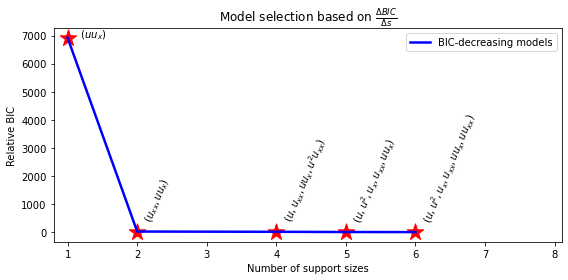

In [20]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(complexities, relative_decreasing_aics, color='blue', linewidth=2.5, label="BIC-decreasing models")
ax.scatter(complexities, relative_decreasing_aics, marker='*', c='red', s=300)
for com, name, rel_aic in zip(complexities, eff_feature_names, relative_decreasing_aics):
    rotation = (90+45)/2
    if com == 1: rotation = 0
    ax.annotate(f"    $({','.join(name)})$", (com, rel_aic), rotation=rotation)
plt.xlim(0.8,8.1)
plt.title(r"Model selection based on $\frac{\Delta BIC}{\Delta s}$")
plt.ylabel("Relative BIC")
plt.xlabel("Number of support sizes")
plt.legend()
plt.tight_layout()
# plt.savefig(join_path(FIGURE_EXPORT_PATH, "aic_model_selection.png"), dpi=300)
plt.show()

In [21]:
good_coms = set()
min_pok = 0.01
max_pok = 1./2
delta_pok = min_pok
for p in np.arange(min_pok, max_pok+delta_pok, delta_pok):
    c = find_transition_V5(decreasing_aics, complexities, percent_ok=p)
    if c == 1: break
    good_coms.add(c)
good_coms

2 improves 1
Percent improve: 0.11140732979759456
5 does not improve 2
Percent improve: 8.231958156972415e-05
2 improves 1
Percent improve: 0.11140732979759456
5 does not improve 2
Percent improve: 8.231958156972415e-05
2 improves 1
Percent improve: 0.11140732979759456
5 does not improve 2
Percent improve: 8.231958156972415e-05
2 improves 1
Percent improve: 0.11140732979759456
5 does not improve 2
Percent improve: 8.231958156972415e-05
2 improves 1
Percent improve: 0.11140732979759456
5 does not improve 2
Percent improve: 8.231958156972415e-05
2 improves 1
Percent improve: 0.11140732979759456
5 does not improve 2
Percent improve: 8.231958156972415e-05
2 improves 1
Percent improve: 0.11140732979759456
5 does not improve 2
Percent improve: 8.231958156972415e-05
2 improves 1
Percent improve: 0.11140732979759456
5 does not improve 2
Percent improve: 8.231958156972415e-05
2 improves 1
Percent improve: 0.11140732979759456
5 does not improve 2
Percent improve: 8.231958156972415e-05
2 improves

{2}

In [22]:
# w/o ksvd_reg denoise: -6899.507440178677
# w/ ksvd_reg denoise: -12216.134372396475
print(smoother_name, n_components)
print(decreasing_aics[1]-decreasing_aics[0])
decreasing_aics, complexities, eff_feature_names

none 32
-6899.507440178677


(array([-61930.46231979, -68829.96975997, -68839.43122012, -68846.9679229 ,
        -68849.59980368]),
 array([1, 2, 4, 5, 6]),
 [['uu_{x}'],
  ['u_{xx}', 'uu_{x}'],
  ['u', 'u_{xx}', 'uu_{x}', 'u^2u_{xx}'],
  ['u', 'u^2', 'u_{x}', 'u_{xx}', 'uu_{x}'],
  ['u', 'u^2', 'u_{x}', 'u_{xx}', 'uu_{x}', 'uu_{xx}']])

#### More model selection

In [23]:
# Use PDE_FIND_Loss from parametric_pde_find.py by formulating as a parametric problem
# Moving horizon in time

def ssr2llf(ssr, nobs):
    nobs2 = nobs / 2.0
    llf = -nobs2 * np.log(2 * np.pi) - nobs2 * np.log(ssr / nobs) - nobs2
    return llf

def log_like_value(prediction, ground):                                                                                                               
    nobs = float(ground.shape[0])
    ssr = np.sum(np.abs(ground - prediction)**2)
    def ssr2llf(ssr, nobs):
        nobs2 = nobs / 2.0
        llf = -nobs2 * np.log(2 * np.pi) - nobs2 * np.log(ssr / nobs) - nobs2
        return llf
    return ssr2llf(ssr, nobs)

def BIC_AIC(prediction, ground, nparams, reg_func = lambda x: x):
    nparams = reg_func(nparams)
    llf = log_like_value(prediction, ground)
    return -2*llf + np.log(ground.shape[0])*nparams, -2*llf + 2*nparams

def AIC_Loss(A,b,x,epsilon=1e-5):
    N = A.shape[0]
    k = np.count_nonzero(x)
    # Rudy et al., 2019
    rss = ((b-A.dot(x))**2).sum()
    aic = N*np.log(rss/N+epsilon) + 2*k + (2*k**2+2*k)/(N-k-1)
    return aic

def PDE_FIND_Loss(As,bs,x,epsilon=1e-5,const_coeff=True,cv=0,ic_type="bic",version=0):
    # D: Number of candidates | m: either len(t) or len(x) (temporal or spatial group)
    D,m = x.shape
    # n: Number of horizon
    n,_ = As[0].shape
    N = n*m
    
    rss = [np.linalg.norm(bs[j] - As[j].dot(x[:,j].reshape(D,1)))**2 for j in range(m)]
    rss = np.sum(rss)
    llf = ssr2llf(rss, N)
    
    k = np.count_nonzero(x)
    if const_coeff:
        k = np.count_nonzero(x)/m
    k = k + k*cv
    
    if ic_type == "aic":
        aic1 = N*np.log(rss/N+epsilon) + 2*k + (2*k**2+2*k)/(N-k-1)
        aic2 = -2*llf + 2*k + (2*k**2+2*k)/(N-k-1)
        if version > 0:
            return aic2
        return aic1
    elif ic_type == "bic":
        bic1 = N*np.log(rss/N+epsilon) + np.log(N)*k
        bic2 = -2*llf + np.log(N)*k
        if version > 0:
            return bic2
        return bic1

#### Consider uncert from BayesianRidge (brr)

[0.00559118 0.00499471 0.00667731 0.01348801 0.03050938 0.03613925
 0.04953412 0.14418332]
[ 1.11941947  1.          1.33687645  2.7004588   6.10833585  7.23550233
  9.91731436 28.86719684]
3,3,3,3,3,2,2,2,2,

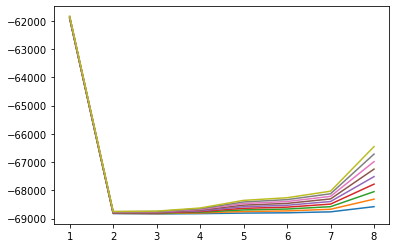

In [24]:
# baye_alpha = 1e-6
# mul_val = 1
# brr_uncertainties = []
# brr_bics = []
# for com in sorted(st.track.keys()):
#     brr = BayesianRidge(compute_score=True, alpha_1=baye_alpha, alpha_2=baye_alpha)
#     brr.fit(X_pre[:, st.track[com][0]], y_pre)
#     uncert = mul_val*np.trace(np.sqrt(brr.sigma_))
#     brr_uncertainties.append(uncert)
#     brr_bics.append((brr.predict(X_pre[:, st.track[com][0]]).reshape(-1, 1), 
#                      np.count_nonzero(brr.coef_), 
#                      uncert))
# brr_uncertainties = np.array(brr_uncertainties)

# power = 0
# while 1:
#     e = brr_uncertainties.min()*(10**power)
#     if e > 1: break
#     power += 1
# mul_val = 10**power
# brr_uncertainties = brr_uncertainties*mul_val
# print(brr_uncertainties)

# for kkk in range(1, 10):
#     brr_bicaics = [BIC_AIC(brr_pred, y_pre, brr_com+kkk*mul_val*brr_uncert)[0] 
#                    for brr_pred, brr_com, brr_uncert in brr_bics]
#     print(np.argmin(brr_bicaics)+1, end=',')
#     plt.plot(brr_bicaics)
# plt.show()

baye_alpha = 1e-6
mul_val = 1
brr_uncertainties = []
brr_bics = []
for com in sorted(st.track.keys()):
    brr = BayesianRidge(compute_score=True, alpha_1=baye_alpha, alpha_2=baye_alpha)
    brr.fit(X_pre[:, st.track[com][0]], y_pre)
    _, prediction_std = brr.predict(X_pre[:, st.track[com][0]], return_std=True)
    # uncert = np.trace(np.sqrt(brr.sigma_))
    uncert = np.sqrt(np.diag(brr.sigma_)).sum()
    brr_uncertainties.append(uncert)
    brr_bics.append((brr.predict(X_pre[:, st.track[com][0]]).reshape(-1, 1), 
                     np.count_nonzero(brr.coef_), 
                     uncert))
    
brr_uncertainties = np.array(brr_uncertainties)
print(brr_uncertainties)
mul_val = 1/brr_uncertainties.min()
print(brr_uncertainties*mul_val)

for kkk in range(1, 10):
    brr_bicaics = [BIC_AIC(brr_pred, y_pre, brr_com+kkk*mul_val*brr_uncert)[0] 
                   for brr_pred, brr_com, brr_uncert in brr_bics]
    print(np.argmin(brr_bicaics)+1, end=',')
    plt.plot([i+1 for i in range(len(brr_bicaics))], brr_bicaics)
plt.show()

In [25]:
from UBIC import *

In [26]:
_, _, b_uns = baye_uncertainties([v[0] for v in st.track.values()], (X_pre, y_pre), ridge_lambda=0)
b_uns

array([ 1.11932805,  1.        ,  1.26054995,  2.66681646,  6.02179183,
        6.2671206 ,  8.83154437, 28.32321817])

In [27]:
ics, bc, lam = UBICs([v[0] for v in st.track.values()], (X_pre, y_pre))
ics[-3], bc, lam

n_lams = 3
Using OLS's uncertainties
[ 1.11928223  1.          1.26061159  2.66710192  6.02310254  6.26880714
  8.83475586 28.39940575]
0 ---> 2
1.0 ---> 2
2.0 ---> 2
[-61920.15334948 -68820.7594196  -68817.20439491 -68814.86630366
 -68791.49309841 -68791.8619562  -68762.53749709 -68573.86249587]
The optimal complexity is currently at the support sizes of 2.


(array([-61920.15334948, -68820.7594196 , -68817.20439491, -68814.86630366,
        -68791.49309841, -68791.8619562 , -68762.53749709, -68573.86249587]),
 1,
 0)

In [28]:
n_lams = 3
ics, bc, lam = UBICs([v[0] for v in st.track.values()], 
                     (X_pre, y_pre), 
                     u_type='cv', take_sqrt=True, use_baye=True, 
                     delta=(1+1/3), n_lams=n_lams)
ics[-n_lams], bc, lam

n_lams = 3
Using baye_uncertainties
[ 1.30633581  1.          1.25863511  2.57242136  5.93973621  6.21494908
  8.6956885  27.40698055]
0 ---> 2
1.3333333333333333 ---> 2
2.6666666666666665 ---> 2
[-61918.43052239 -68820.7594196  -68817.22259894 -68815.73834385
 -68792.2609307  -68792.35800727 -68763.81835487 -68583.0030697 ]
The optimal complexity is currently at the support sizes of 2.


(array([-61918.43052239, -68820.7594196 , -68817.22259894, -68815.73834385,
        -68792.2609307 , -68792.35800727, -68763.81835487, -68583.0030697 ]),
 1,
 0)

In [29]:
_,_, b_uns = baye_uncertainties([v[0] for v in st.track.values()], (X_pre, y_pre), u_type='cv', take_sqrt=True)
lower_bounds = []
for efi in [v[0] for v in st.track.values()]:
    com = len(efi)
    w = np.linalg.lstsq(X_pre[:, efi], y_pre, rcond=None)[0]
    pred = X_pre[:, efi]@w
    lower_bound = log_like_value(pred, y_pre)/np.log(len(y_pre))-com
    lower_bounds.append(lower_bound)
max_lam = max(np.log10(lower_bounds/b_uns))
delta = np.linspace(0, max_lam, 4)[1]
max_lam

3.572355659062238

In [30]:
n_lams = 3
ics, bc, lam = UBICs([v[0] for v in st.track.values()], 
                     (X_pre, y_pre), 
                     u_type='cv', take_sqrt=True, use_baye=True, 
                     max_lam=max_lam,
                     delta=delta, 
                     n_lams=n_lams)
ics[-n_lams], bc, lam

n_lams = 3
Using baye_uncertainties
[ 1.30633581  1.          1.25863511  2.57242136  5.93973621  6.21494908
  8.6956885  27.40698055]
0 ---> 2
1.1907852196874127 ---> 2
2.3815704393748254 ---> 2
[-61918.43052239 -68820.7594196  -68817.22259894 -68815.73834385
 -68792.2609307  -68792.35800727 -68763.81835487 -68583.0030697 ]
The optimal complexity is currently at the support sizes of 2.


(array([-61918.43052239, -68820.7594196 , -68817.22259894, -68815.73834385,
        -68792.2609307 , -68792.35800727, -68763.81835487, -68583.0030697 ]),
 1,
 0)

In [31]:
best_subsets = sorted([v[0] for v in st.track.values()], key=len)
ols_models = [sm.OLS(y_pre, X_pre[:, efi]).fit() for efi in best_subsets]
f_res = sm.stats.anova_lm(*ols_models, test="F", robust="hc3") # "F", "Chisq"", "Cp"
print(np.argmax(f_res.F)+1)
f_res

2


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,9999.0,1.195418,0.0,NaN,NaN,NaN
1,9998.0,0.599071,1.0,0.596347,10007.162391,0.000000
2,9997.0,0.598588,1.0,0.000482,8.094957,0.004448
3,9996.0,0.597403,1.0,0.001186,19.895526,0.000008
4,9995.0,0.596403,1.0,0.001000,16.774640,0.000042
5,9994.0,0.595697,1.0,0.000706,11.844791,0.000581
6,9993.0,0.595488,1.0,0.000210,3.517203,0.060764
7,9992.0,0.595444,1.0,0.000044,0.731865,0.392300


In [32]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from k_means_constrained import KMeansConstrained

clf = KMeansConstrained(
    n_clusters=2, size_min=1, size_max=len(complexities)-1, 
    random_state=0, 
)
clf.fit(np.vstack((decreasing_aics, complexities)).T)
# silhouette_avg = silhouette_score(X, clf.labels_)
clf.labels_,  clf.cluster_centers_

(array([1, 0, 0, 0, 0], dtype=int32),
 array([[-6.88414922e+04,  4.25000000e+00],
        [-6.19304623e+04,  1.00000000e+00]]))

In [33]:
model = sm.OLS(y_pre, X_pre[:, efi])
res = model.fit()

In [34]:
model.loglike(res.params), log_like_value(X_pre[:, efi]@res.params.reshape(-1, 1), y_pre)

(34454.556706063064, 34454.556706063064)

#### UBIC

In [35]:
# 100% success rate
tau = 3
thresholds = np.arange(0.001, 0.1+0.001, 0.001)
verbose = False

post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre, y_pre), u_type='cv1', take_sqrt=True)
predictions = X_pre@post_means
lower_bounds = []
for k, efi in enumerate(best_subsets):
    assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
    com = len(efi)
    lower_bound = 2*log_like_value(predictions[:, k:k+1], y_pre)/np.log(len(y_pre))-com
    lower_bounds.append(lower_bound)
    
for thres in thresholds:
    last_lam = np.log10(max(lower_bounds/b_uns))
    delta = last_lam/tau
    now_lam = last_lam-delta
    last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam)
    last_bc = np.argmin(last_ubic)
    
    while now_lam > 0:
        now_lam = last_lam-delta
        now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam)
        now_bc = np.argmin(now_ubic)

        diff_com = now_bc-last_bc
        diff_bic = b_bics[now_bc]-b_bics[last_bc]
        imp = abs(diff_bic/(b_bics[last_bc]*diff_com))

        if verbose:
            print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), 
                  np.nan_to_num(imp, nan=np.inf))
        
        if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
            (diff_com < 0 and diff_bic > 0 and imp > thres):
            break

        last_lam = now_lam
        now_lam = last_lam-delta
        last_ubic = now_ubic
        last_bc = now_bc

    last_lam = round(last_lam, 10)
    # last_lam, last_ubic, last_bc
    print(last_bc, end=', ')

1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [36]:
tau = 3
thres = 0.02
verbose = True

post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre, y_pre), u_type='cv1', take_sqrt=True)
predictions = X_pre@post_means
lower_bounds = []
for k, efi in enumerate(best_subsets):
    assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
    com = len(efi); print(com)
    lower_bound = 2*log_like_value(predictions[:, k:k+1], y_pre)/np.log(len(y_pre))-com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/b_uns))
print("max_lam:", last_lam)
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam)
last_bc = np.argmin(last_ubic)
while now_lam > 0:
    now_lam = last_lam-delta
    now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    
    if verbose:
        print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), 
              np.nan_to_num(imp, nan=np.inf))
    
#     if (diff_com > 0 and imp < thres) or (diff_com < 0 and imp > thres):
#         break
    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = last_lam-delta
    last_ubic = now_ubic
    last_bc = now_bc

best_bc = last_bc
if abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres:
    best_bc = best_bc - 1
    
last_lam = round(last_lam, 10)
last_lam, last_ubic, last_bc, best_bc

1
2
3
4
5
6
7
8
max_lam: 3.873501898721712
1 <---> 1 inf
1 <---> 1 inf
1 <---> 1 inf


(0.0,
 array([-61918.43052239, -68820.7594196 , -68817.22259894, -68815.73834385,
        -68792.2609307 , -68792.35800727, -68763.81835487, -68583.0030697 ]),
 1,
 1)

In [37]:
_, b_aics, _ = baye_uncertainties_aic(best_subsets, (X_pre, y_pre), u_type='cv1', take_sqrt=True)

In [38]:
np.array(b_aics)-np.array(b_bics) # np.log(len(y_pre))-2

array([ -7.21034037, -14.42068074, -21.63102112, -28.84136149,
       -36.05170186, -43.26204223, -50.4723826 , -57.68272298])

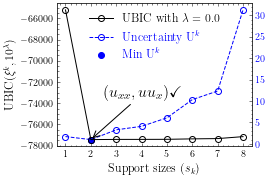

In [36]:
complexity_axis = list(st.track.keys())
with plt.style.context(['science']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.set_zorder(ax2.get_zorder()+1)
    ax.patch.set_visible(False)
    
    l1, = ax.plot(complexity_axis, last_ubic, 'o-', c='black', markerfacecolor='none', label=f"$\lambda = {abs(last_lam)}$")
    ax.set_xticks(complexity_axis)
    ax.set_ylabel("$\\textrm{UBIC}(\\xi^{k}, 10^{\\lambda})$", fontsize=12)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)
    ax.annotate('$(u_{xx}, uu_{x})\checkmark$', fontsize=16, 
                 xy=(complexity_axis[best_bc], last_ubic[best_bc]), 
                 xytext=(complexity_axis[best_bc]+0.5, last_ubic[best_bc]+4000), 
                 arrowprops={'arrowstyle': '->'})
    
    l2, = ax2.plot(complexity_axis, b_uns, 'o--', c='blue', markerfacecolor='none', label="Uncertainty $\\textrm{U}^{k}$")
    s1 = ax2.scatter(complexity_axis[np.argmin(b_uns)], b_uns[np.argmin(b_uns)], c='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    ax.legend([l1, l2, s1], [f"UBIC with $\lambda = {abs(last_lam)}$", "Uncertainty $\\textrm{U}^{k}$", "Min $\\textrm{U}^{k}$"], 
              labelcolor='linecolor', loc='upper center', fontsize=12)
    
#     fig.savefig("../Figures/Burgers/burgers_ubic_V2.pdf")
    
    plt.show()

In [38]:
h5file(file_path="../Visualization/figure1/Burgers/ubic_plot.h5", 
       cdict={'complexity_axis': complexity_axis, 'last_ubic': last_ubic, 'b_uns': b_uns, 'best_bc': np.array([best_bc]), 'last_lam': np.array([last_lam])}, 
       mode='w'
      )

(array([ 1.70552385,  1.        ,  3.28222831,  4.09796083,  6.08513976,
        10.33654514, 12.34072273, 31.27730218]),
 array([1]),
 array([1, 2, 3, 4, 5, 6, 7, 8]),
 array([0.]),
 array([-65207.60451348, -77430.2372346 , -77411.35282454, -77409.46120483,
        -77403.12069533, -77361.11989089, -77334.10458529, -77150.49229761]))

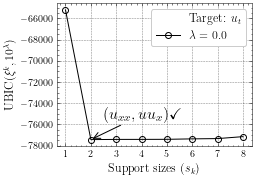

In [39]:
save_fig = True # True, False
complexity_axis = list(st.track.keys())
with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots()
    ax.plot([], [], linestyle='', marker='', label='Target: $u_t$')
    ax.plot(complexity_axis, last_ubic, 'o-', c='black', markerfacecolor='none', label=f"$\lambda = {abs(last_lam)}$")
    ax.set_xticks(complexity_axis)
    ax.set_ylabel("$\\textrm{UBIC}(\\xi^{k}, 10^{\\lambda})$", fontsize=12)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)
    plt.annotate('$(u_{xx}, uu_{x})\checkmark$', fontsize=16, 
                 xy=(complexity_axis[best_bc], last_ubic[best_bc]), 
                 xytext=(complexity_axis[best_bc]+0.5, last_ubic[best_bc]+2000), 
                 arrowprops={'arrowstyle': '->'})
    ax.legend(fontsize=12)
#     if save_fig: fig.savefig("../Figures/Burgers/burgers_ubic.pdf")
    plt.show()
    plt.close()

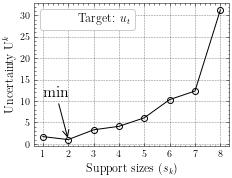

In [40]:
save_fig = True # True, False
complexity_axis = list(st.track.keys())
with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots()
    ax.plot([], [], linestyle='', marker='', label='Target: $u_t$')
    ax.plot(complexity_axis, b_uns, 'o-', c='black', markerfacecolor='none')
    ax.set_xticks(complexity_axis)
    ax.set_ylabel("Uncertainty $\\textrm{U}^{k}$", fontsize=12)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)
    plt.annotate('min', fontsize=16, 
                 xy=(complexity_axis[best_bc], b_uns[best_bc]), 
                 xytext=(complexity_axis[best_bc]-1, b_uns[best_bc]+10), 
                 arrowprops={'arrowstyle': '->'})
    ax.legend(fontsize=12)
#     if save_fig: fig.savefig("../Figures/Burgers/burgers_uns.pdf")
    plt.show()
    plt.close()

['X_pre', 'best_subsets', 'un', 'y_pre']


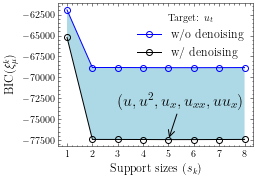

In [41]:
ud_X, un_best_subsets, _, ud_y = h5file("./IPI_output_files/PMS_undenoised_data.h5", 'r')
_, ud_bics, _ = baye_uncertainties([np.where(e>0)[0].tolist() for e in un_best_subsets], 
                                   (ud_X, ud_y), u_type='cv1', take_sqrt=True)

save_fig = True # True, False
complexity_axis = list(st.track.keys())
with plt.style.context(['science']):
    fig, ax = plt.subplots()
    ax.plot(complexity_axis, ud_bics, 'o-', c='blue', markerfacecolor='none', label="w/o denoising")
    ax.plot(complexity_axis, b_bics, 'o-', c='black', markerfacecolor='none', label="w/ denoising")
    ax.fill_between(complexity_axis, ud_bics, b_bics, facecolor='lightblue')
    ax.set_xticks(complexity_axis)
    ax.set_ylabel("$\\textrm{BIC}(\\xi^{k}_{\\mu})$", fontsize=12)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)
    plt.annotate(f"$({', '.join(eff_feature_names[np.argmin(b_bics)])})$", fontsize=16, 
                 xy=(complexity_axis[np.argmin(b_bics)], b_bics[np.argmin(b_bics)]), 
                 xytext=(complexity_axis[np.argmin(b_bics)]-2, b_bics[np.argmin(b_bics)]+4000), 
                 arrowprops={'arrowstyle': '->'})
    ax.legend(fontsize=12, title='Target: $u_t$')
    if save_fig: fig.savefig("../Figures/Burgers/burgers_bic_V2.pdf")
    plt.show()
    plt.close()

In [42]:
h5file(file_path="../Visualization/figure1/Burgers/bic_plot.h5", 
       cdict={'ud_bics': ud_bics, 'b_bics': b_bics}, 
       mode='w'
      )

(array([-65223.31296864, -77439.44757497, -77441.58326444, -77447.20481893,
        -77459.1669037 , -77456.32298993, -77447.76684203, -77438.56689659]),
 array([-61930.46231979, -68829.96975997, -68828.81505675, -68839.43122012,
        -68846.9679229 , -68849.59980368, -68843.90860571, -68835.43068915]))

In [43]:
eff_feature_names

[['uu_{x}'],
 ['u_{xx}', 'uu_{x}'],
 ['u_{x}', 'u_{xx}', 'uu_{x}'],
 ['u_{x}', 'u_{xx}', 'uu_{x}', 'u^2u_{xx}'],
 ['u', 'u^2', 'u_{x}', 'u_{xx}', 'uu_{x}']]

#### IC on validation data

In [ ]:
div = 2
X_train = X_pre.copy()[:len(X_pre)//div, :]
y_train = y_pre.copy()[:len(X_pre)//div, :]
X_val = X_pre.copy()[len(X_pre)//div:, :]
y_val = y_pre.copy()[len(X_pre)//div:, :]

In [ ]:
post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_train, y_train), 
                                               u_type='cv1', take_sqrt=True)
print(np.argmin(b_bics))
val_pred = X_val@post_means
val_bic_scores = []
for k in range(val_pred.shape[-1]):
    val_bic_scores.append(BIC_AIC(val_pred[:, k:k+1], y_val, 
                                  np.count_nonzero(post_means[:, k:k+1]))[0])
print(np.argmin(val_bic_scores))

In [ ]:
### useful for checking whether it worth having function coefficienst or not? ###
# diff_lib = ps.PDELibrary(library_functions=library_functions, 
#                          function_names=library_function_names, 
#                          derivative_order=2, 
#                          spatial_grid=x, 
#                          is_uniform=True, 
#                          differentiation_method=ps., 
#                          differentiation_kwargs=differentiation_kwargs)

diff_lib = ps.PDELibrary(library_functions=library_functions, 
                         function_names=library_function_names, 
                         derivative_order=2, 
                         spatial_grid=x, 
                         is_uniform=True, 
                         differentiation_method=differentiation_method, 
                         differentiation_kwargs=differentiation_kwargs)

candidate_lib = diff_lib.fit_transform(np.expand_dims(un[:, :], -1))
f_candidate_lib = np.stack([np.fft.fft2(candidate_lib[:, :, i]) 
                            for i in range(candidate_lib.shape[-1])], axis=-1)
candidate_lib = candidate_lib.reshape(-1, candidate_lib.shape[-1])
dynamics = diff_lib.differentiation_method(**diff_lib.differentiation_kwargs, 
                                           axis=1)._differentiate(un[:, :], 
                                                                  t)
f_dynamics = np.fft.fft2(dynamics)
dynamics = dynamics.reshape(-1,1)

dependent = "temporal"
Theta_grouped, Ut_grouped = spatial_temporal_group(candidate_lib, dynamics, 
                                                   (len(x), len(t)), 
                                                   dependent=dependent)

com2coeff = {}
com2paracoeff = {}
for com in sorted(st.track.keys()):
    indices, _ = st.track[com]
    paracoeff = np.zeros(shape=(candidate_lib.shape[-1], len(Theta_grouped)))
    
    paracoeff[list(indices)] = np.hstack([np.linalg.lstsq(Theta_grouped[_][:, indices], 
                                                          Ut_grouped[_], 
                                                          rcond=None)[0] for _ in range(len(Theta_grouped))])
    
    coeff = np.zeros(shape=(candidate_lib.shape[-1], 1))
    coeff[list(indices)] = np.linalg.lstsq(candidate_lib[:, indices], dynamics)[0]
    coeff = np.hstack([coeff for _ in range(len(Theta_grouped))])
    
    com2coeff[com] = coeff
    com2paracoeff[com] = paracoeff

In [ ]:
PDE_Losses = np.array([PDE_FIND_Loss(Theta_grouped, Ut_grouped, com2coeff[com])
                       for com in sorted(st.track.keys())])
paraPDE_Losses = np.array([PDE_FIND_Loss(Theta_grouped, Ut_grouped, com2paracoeff[com], const_coeff=False)
                       for com in sorted(st.track.keys())])

### decide whether you are dealing with functional coefficients here ###
plt.plot(sorted(st.track.keys()), PDE_Losses, label='const')
plt.plot(sorted(st.track.keys()), paraPDE_Losses, label='para')
plt.legend()
plt.show()

In [ ]:
# 5 to 10 percent as threshold
print(np.min(paraPDE_Losses-PDE_Losses)/PDE_Losses[np.argmin(paraPDE_Losses-PDE_Losses)])
plt.plot(sorted(st.track.keys()), paraPDE_Losses-PDE_Losses)
plt.show()

In [ ]:
if dependent == "temporal":
    plt.plot(t, com2paracoeff[2][list(st.track[2][0])][0])
    plt.plot(t, com2paracoeff[2][list(st.track[2][0])][1])
elif dependent == "spatial":
    plt.plot(x, com2paracoeff[2][list(st.track[2][0])][0])
    plt.plot(x, com2paracoeff[2][list(st.track[2][0])][1])
plt.show()

In [ ]:
maxi = np.max(t); mini = np.min(t)
mid = (mini+maxi)/2
ss = np.arange(0, len(t)-(list(t).index(mid)), dtype=np.int)

com2coeff_sub = {}
for s in ss:
    t_sub_indices = [i+s for i in range(list(t).index(mid)+1)]
    t_sub = t[t_sub_indices]
    un_sub = (un.copy())[:, t_sub_indices]
    print(t_sub_indices[0], "->", t_sub_indices[-1])

    diff_lib = ps.PDELibrary(library_functions=library_functions, 
                             function_names=library_function_names, 
                             derivative_order=2, 
                             spatial_grid=x, 
                             is_uniform=True, 
                             differentiation_method=ps.SmoothedFiniteDifference, 
                             differentiation_kwargs=differentiation_kwargs)

    candidate_lib_sub = diff_lib.fit_transform(np.expand_dims(un_sub, -1))
    candidate_lib_sub = candidate_lib_sub.reshape(-1, candidate_lib_sub.shape[-1])
    dynamics_sub = diff_lib.differentiation_method(**diff_lib.differentiation_kwargs, 
                                                   axis=1)._differentiate(un_sub, 
                                                                          t_sub).reshape(-1,1)
    
    Theta_grouped_sub, Ut_grouped_sub = spatial_temporal_group(candidate_lib_sub, dynamics_sub, 
                                                               (len(x), len(t_sub)), 
                                                               dependent=dependent)
    
    for com in sorted(st.track.keys()):
        indices, _ = st.track[com]
        
        coeff = np.hstack([np.linalg.lstsq(Theta_grouped_sub[_][:, indices], 
                                           Ut_grouped_sub[_], 
                                           rcond=None)[0] for _ in range(len(Theta_grouped_sub))])

#         coeff = np.zeros(shape=(candidate_lib_sub.shape[-1], 1))
#         coeff[list(indices)] = np.linalg.lstsq(candidate_lib_sub[:, indices], dynamics_sub)[0]
#         coeff = np.hstack([coeff for _ in range(n)])

        coeff = np.expand_dims(coeff, 0)
        if com not in com2coeff_sub: 
            com2coeff_sub[com] = coeff
        else: 
            com2coeff_sub[com] = np.vstack((com2coeff_sub[com], coeff))

In [ ]:
# cvs = np.zeros((len(st.track.keys()), len(diff_lib.get_feature_names())))
# for com in sorted(st.track.keys()):
#     indices, _ = st.track[com]
#     cv_com = np.zeros(len(diff_lib.get_feature_names()))
    
#     ### treat a seq of coeff values in one horizon as a mean constant number ###
#     mh_coeffs = np.mean(com2coeff_sub[com], axis=-1)
#     cv = np.std(mh_coeffs, axis=0)/np.mean(mh_coeffs, axis=0)
#     cv = cv[~np.isnan(cv)]
#     cv_com[list(indices)] = np.abs(cv)
    
#     ### mean over the horizon axis as well
#     # cv = np.abs(com2coeff_sub[com].std(axis=0)/com2coeff_sub[com].mean(axis=0)).mean(axis=-1)
#     # cv = cv[~np.isnan(cv)]
    
#     cv_com[list(indices)] = np.abs(cv)
#     cvs[com-1] = cv_com

# cvs.sum(axis=-1)

cvs = np.zeros((len(st.track.keys()), len(diff_lib.get_feature_names())))
for com in sorted(st.track.keys()):
    indices, _ = st.track[com]
    cv_com = np.zeros(len(diff_lib.get_feature_names()))
    
    ### treat a seq of coeff values in one horizon as a mean constant number ###
    mh_coeffs = np.mean(com2coeff_sub[com], axis=-1)
    cv_com[list(indices)] = np.abs(np.std(mh_coeffs, axis=0)/np.mean(mh_coeffs, axis=0))
    
    ### mean over the horizon axis as well
    # cv_com[list(indices)] = np.abs(com2coeff_sub[com].std(axis=0)/com2coeff_sub[com].mean(axis=0)).mean(axis=-1)
    
    cvs[com-1] = cv_com
    
cvs.sum(axis=-1)

In [ ]:
brr_bicaics = [BIC_AIC(brr_pred, y_pre, brr_com+cvs.sum(axis=-1)[brr_com-1])[0] 
               for brr_pred, brr_com, brr_uncert in brr_bics]
print(np.argmin(brr_bicaics)+1)
plt.plot(brr_bicaics)
plt.show()

#### Denoised weak form: Tune (p, q), ws

In [ ]:
def weight_poly(x, m, k):
    """
    Polynomial piece of weighting function used to satisfy BC A = d^k/dx^k[(x^2 - 1)^m]
    x: independent variable
    m: power of base function
    k: order of derivative
    """
    a = np.zeros((2*m+1, 1)) # initial coefficient vector
    for l in range(m+1):
        a[2*l] = ((-1)**(m-l))*np.math.comb(m, l) # set polynomial coefficients
    
    c = np.zeros((2*m+1, 1)) # final coefficient vector
    for n in range(2*m-k+1):
        c[n] = a[n+k]*np.math.factorial(n+k)/np.math.factorial(n)
    
    p = 0
    for n in range(2*m-k+1):
        p += c[n]*(x**n) # final windowing function

    return p

def weight_full(k, p, x, t):
    """
    Assemble the 1D weight functions into the full weight
    k = [kx,ky,kt]: order of derivative(s)
    p = [px,py,pt]: exponents of weight polynomials
    """
    if len(k) == 3:
        wx = weight_poly(x, p[0], k[0])
        wy = weight_poly(x, p[1], k[1])
        wt = weight_poly(t, p[2], k[2])
        wX, wY, wT = np.meshgrid(wx, wy, wt)
        W = wX * wY * wT
    elif len(k) == 2:
        wx = weight_poly(x, p[0], k[0])
        wt = weight_poly(t, p[1], k[1])
        wT, wX = np.meshgrid(wt, wx)
        W = wX * wT
    
    return W, wx, wt

In [ ]:
u_weak = un.copy()
n_domain = 10000
div = 3.5
x_size, t_size = int(max(u_weak.shape)/div), int(max(u_weak.shape)/div)

xsup = np.linspace(-1,1,x_size+1)
tsup = np.linspace(-1,1,t_size+1)
S_x = 2/(dx*x_size)
S_t = 2/(dt*t_size)

In [ ]:
max_order = 2
best_loss = 1e6; best_coeff = None
for mo in range(max_order, max_order+10, 1):
    wx, wt = np.meshgrid((xsup**2-1)**(mo), (tsup**2-1)**(mo))
    W = (wx*wt).T
    
    # Define the derivative:
    d_dx = FinDiff(0, xsup[1]-xsup[0], 1)
    d_dxx = FinDiff(0, xsup[1]-xsup[0], 2)
    d_dxxxx = FinDiff(0, xsup[1]-xsup[0], 4)
    d_dt = FinDiff(1, tsup[1]-tsup[0], 1)

    dA01 = d_dt(W)
    dA10 = d_dx(W)
    dA20 = d_dxx(W)
    dA40 = d_dxxxx(W)

    X_weak = []
    y_weak = []
    for _ in trange(n_domain):
        ix = np.random.randint(0, len(x)-x_size, size=1)[0] + np.arange(0, x_size+1)
        it = np.random.randint(0, len(t)-t_size, size=1)[0] + np.arange(0, t_size+1)

        usup = (u_weak[ix, :][:, it])

        f1 = -(1/2)*(usup**2)*dA10*S_x
        f1 = trapz(trapz(f1, tsup, dt, 1), xsup, dx, 0)

        f2 = usup*dA20*(S_x**2)
        f2 = trapz(trapz(f2, tsup, dt, 1), xsup, dx, 0)

        X_weak.append([f2, f1])

        f4 = -usup*dA01*S_t
        f4 = trapz(trapz(f4, tsup, dt, 1), xsup, dx, 0)
        y_weak.append(f4)

    X_weak = np.array(X_weak)
    y_weak = np.array(y_weak)

    coeff = np.linalg.lstsq(X_weak, y_weak, rcond=None)[0]
    loss = ((X_weak@coeff-y_weak)**2).mean()

    print(mo)
    print(loss, evaluate_coefficients(coeff))
    if loss < best_loss:
        best_loss = loss
        best_coeff = coeff
    else:
        break

best_mo = mo-1
best_coeff, evaluate_coefficients(best_coeff)

#### Savgol_filter

In [ ]:
wx, wt = np.meshgrid((xsup**2-1)**(best_mo), (tsup**2-1)**(best_mo))
W = (wx*wt).T

# Define the derivative:
d_dx = FinDiff(0, xsup[1]-xsup[0], 1, acc=4)
d_dxx = FinDiff(0, xsup[1]-xsup[0], 2, acc=4)
d_dxxxx = FinDiff(0, xsup[1]-xsup[0], 4, acc=4)
d_dt = FinDiff(1, tsup[1]-tsup[0], 1, acc=4)

dA01 = d_dt(W)
dA10 = d_dx(W)
dA20 = d_dxx(W)
dA40 = d_dxxxx(W)

min_loss = 1e6; best_coeff = None
for ws in trange(3, 33, 2):
    X_weak = []
    y_weak = []
    for _ in range(n_domain):
        ix = np.random.randint(0, len(x)-x_size, size=1)[0] + np.arange(0, x_size+1)
        it = np.random.randint(0, len(t)-t_size, size=1)[0] + np.arange(0, t_size+1)
        
        usup = savgol_filter(u_weak[ix, :][:, it], ws, 2)

        f1 = -(1/2)*(usup**2)*dA10*S_x
        f1 = trapz(trapz(f1, tsup, 1), xsup, 0)

        f2 = usup*dA20*(S_x**2)
        f2 = trapz(trapz(f2, tsup, 1), xsup, 0)

        X_weak.append([f2, f1])

        f4 = -usup*dA01*S_t
        f4 = trapz(trapz(f4, tsup, 1), xsup, 0)
        y_weak.append(f4)

    X_weak = np.array(X_weak)
    y_weak = np.array(y_weak)
    
    coeff = np.linalg.lstsq(X_weak, y_weak, rcond=None)[0]
    loss = ((X_weak@coeff-y_weak)**2).mean()
    if loss < min_loss:
        min_loss = loss
        best_coeff = coeff

# (0.03524781993990561, 0.011424239600747732)
min_loss, best_coeff, evaluate_coefficients(best_coeff)

#### wiener

In [ ]:
min_loss = 1e6; best_coeff = None
for ws in trange(3, 33, 1):
    X_weak = []
    y_weak = []
    for _ in range(n_domain):
        ix = np.random.randint(0, len(x)-x_size, size=1)[0] + np.arange(0, x_size+1)
        it = np.random.randint(0, len(t)-t_size, size=1)[0] + np.arange(0, t_size+1)
        
        usup = wiener(u_weak[ix, :][:, it], ws)

        f1 = -(1/2)*(usup**2)*dA10*S_x
        f1 = trapz(trapz(f1, tsup, 1), xsup, 0)

        f2 = usup*dA20*(S_x**2)
        f2 = trapz(trapz(f2, tsup, 1), xsup, 0)

        X_weak.append([f2, f1])

        f4 = -usup*dA01*S_t
        f4 = trapz(trapz(f4, tsup, 1), xsup, 0)
        y_weak.append(f4)

    X_weak = np.array(X_weak)
    y_weak = np.array(y_weak)
    
    coeff = np.linalg.lstsq(X_weak, y_weak, rcond=None)[0]
    loss = ((X_weak@coeff-y_weak)**2).mean()
    if loss < min_loss:
        min_loss = loss
        best_coeff = coeff

# (0.4346650845124686, 0.23677533103052956)
min_loss, best_coeff, evaluate_coefficients(best_coeff)

In [ ]:
raise SystemExit("Stop right here!")

#### Save

In [ ]:
best_subsets = sorted([indices for _, (indices, _) in st.track.items()], key=lambda _: len(_))
tmp = np.zeros((len(best_subsets), X_pre.shape[-1]))
for i in range(len(best_subsets)):
    tmp[i:i+1, :][0, best_subsets[i]] = 1.0
best_subsets = tmp.astype(np.float32)
del tmp

pms_data = {nameof(un): un, 
            nameof(X_pre): X_pre, 
            nameof(y_pre): y_pre, 
            nameof(best_subsets): best_subsets}
pms_data

In [ ]:
basic_vars = {'u'}
encoded_feature_names = []
for feature in model.get_feature_names():
    out_feature = []
    last_index = -1
    for i, c in enumerate(feature):
        if i+1 < len(feature) and feature[i+1] in basic_vars:
            last_index = i
            out_feature.append(c+'*')
    out_feature.append(feature[last_index+1:])
    encoded_feature_names.append(''.join(out_feature))
encoded_feature_names = np.array(encoded_feature_names)
encoded_feature_names.tolist()

In [ ]:
for com in sorted(st.track.keys()):
    indices, _ = st.track[com]
    expr = '+'.join(encoded_feature_names[list(indices)])
    print(expr)
    print('----------')
encoded_pde_names = ['+'.join(encoded_feature_names[list(indices)]) for _, (indices, _) 
                     in sorted(st.track.items())]

In [ ]:
import yaml
from omegaconf import OmegaConf
yml = {}
yml["encoded_feature_names"] = encoded_feature_names.tolist()
yml["encoded_pde_names"] = encoded_pde_names
yml["information_criterion_score"] = [float(ic) for _, (_, ic) in st.track.items()]

#### Save files for training PINNs & DeepONets

In [ ]:
fp1 = "../Burgers_exp/IPI_output_files/PMS_data.h5"
fp2 = "../Burgers_exp/IPI_output_files/encoded_pde_names.yaml"
fp1, fp2

In [ ]:
h5file(file_path=fp1, cdict=pms_data, mode='w')
OmegaConf.save(config=OmegaConf.create(yml), f=fp2)

In [ ]:
OmegaConf.load(fp2)

In [ ]:
h5file(file_path=fp1, mode='r', return_dict=False)